## Models

We want to create some baseline using common models and then test those mentioned in the article.

1. Direct-Recursive Hybrid LSTM – Combines a recursive strategy (feeding the model’s output back as input for multi-step forecasting) with a direct strategy (training multiple models for each forecast step).
2. CNN-LSTM – Applies 1D convolution layers to multivariate inputs before feeding them to an LSTM.
3. Attention-LSTM – Uses an encoder–decoder framework with an attention mechanism to weight important timesteps.

In [47]:
from datetime import timedelta
import warnings


import polars as pl
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

warnings.filterwarnings("ignore")

In [2]:
device

'cuda'

## Train-test

- We will take last hour as a test, one before as val and train across other samples.
- The samples must be consistent among the blocks
- We must not shuffle data since it's time-dependent

In [3]:
df_full_ticks = pl.read_parquet("../data/processed/tx_blocks_eth_clean.parquet")

In [4]:
print(df_full_ticks.shape)
df_full_ticks.head()

(1658540, 19)


cost,gas,gas_fee_cap,gas_price,tx_time,block_hash,base_fee,gas_limit,gas_used,block_time,open_time,close_time,open,high,low,close,volume,quote_asset_volume,number_of_trades
f64,f64,f64,f64,datetime[μs],str,f64,f64,f64,datetime[μs],datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64
-0.009676,1.43768,-0.159582,-0.159582,2025-04-13 13:22:59,"""0x8dde0f4ac2de2c39f15094639fb4…",0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047
-0.021672,-0.151875,0.419496,0.419496,2025-04-13 13:22:59,"""0x8dde0f4ac2de2c39f15094639fb4…",0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047
5.813776,0.622033,256.684807,256.684807,2025-04-13 13:22:59,"""0x8dde0f4ac2de2c39f15094639fb4…",0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047
5.813776,0.622033,256.684807,256.684807,2025-04-13 13:22:59,"""0x8dde0f4ac2de2c39f15094639fb4…",0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047
0.026129,0.461073,2.197437,2.197437,2025-04-13 13:22:59,"""0x8dde0f4ac2de2c39f15094639fb4…",0.152506,-0.50167,-0.50167,2025-04-13 13:22:59,2025-04-13 13:22:59,2025-04-13 13:22:59.000999,-0.765297,-0.76752,-0.763006,-0.765297,0.489824,0.478077,-0.186047


In [5]:
max_time = df_full_ticks["tx_time"].max()
test_threshold = max_time - timedelta(hours=1)
val_threshold = test_threshold - timedelta(hours=1)

test_threshold, val_threshold

(datetime.datetime(2025, 4, 13, 12, 43, 23),
 datetime.datetime(2025, 4, 13, 11, 43, 23))

In [6]:
df_blocks = df_full_ticks.group_by("block_hash").agg(pl.col("tx_time").min().alias("block_time"))

In [7]:
df = df_full_ticks.join(df_blocks, on="block_hash", how="left")

In [8]:
train_df = df.filter(pl.col("block_time") < val_threshold)
val_df = df.filter((pl.col("block_time") >= val_threshold) & (pl.col("block_time") < test_threshold))
test_df = df.filter(pl.col("block_time") >= test_threshold)

In [9]:
train_df.shape, val_df.shape, test_df.shape

((1497811, 20), (85159, 20), (75570, 20))

In [10]:
cols_to_drop = ["tx_time", "block_hash", "block_time", "open_time", "close_time", "block_time_right"]

train_df = train_df.drop(cols_to_drop)
val_df = val_df.drop(cols_to_drop)
test_df = test_df.drop(cols_to_drop)

In [11]:
train_df.write_parquet("../data/processed/train.parquet")
val_df.write_parquet("../data/processed/val.parquet")
test_df.write_parquet("../data/processed/test.parquet")

In [12]:
train_df.shape

(1497811, 14)

## Model Architectures

In [13]:
class SequenceDataset(Dataset):
    def __init__(self, df: pl.DataFrame, seq_length: int, target_col: str):
        self.seq_length = seq_length
        feature_columns = [col for col in df.columns if col != target_col]
        self.features = df.select(feature_columns).to_numpy()
        self.targets = df[target_col].to_numpy()

    def __len__(self):
        return self.features.shape[0] - self.seq_length

    def __getitem__(self, idx):
        seq_x = self.features[idx : idx + self.seq_length]
        target = self.targets[idx + self.seq_length]
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor([target], dtype=torch.float32)

In [21]:
class BasicRNN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        output_size,
        dropout_rate=0.5,
    ):
        super(BasicRNN, self).__init__()
        self.rnn = nn.RNN(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out


class BasicLSTM(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        output_size,
        dropout_rate=0.5,
    ):
        super(BasicLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out


class BasicBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(BasicBiLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=True,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers * 2, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers * 2, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out


class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_size,
        conv_filters=9,
        kernel_size=7,
        lstm_hidden_size=100,
        lstm_num_layers=2,
        output_size=1,
        dropout_rate=0.5,
        padding=True,
    ):
        super(CNNLSTM, self).__init__()
        self.input_size = input_size

        pad = kernel_size // 2 if padding else 0
        self.conv1d = nn.Conv1d(
            in_channels=input_size,
            out_channels=input_size * conv_filters,
            kernel_size=kernel_size,
            groups=input_size,
            padding=pad,
        )

        self.lstm = nn.LSTM(
            input_size=input_size * conv_filters,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            dropout=dropout_rate,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_hidden_size, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)
        conv_out = torch.tanh(self.conv1d(x))
        conv_out = conv_out.transpose(1, 2)
        batch_size = conv_out.size(0)
        h0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size, device=x.device)
        c0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size, device=x.device)
        lstm_out, _ = self.lstm(conv_out, (h0, c0))
        out = lstm_out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out


class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, attn_hidden_size):
        super().__init__()
        self.linear_enc = nn.Linear(enc_size, attn_hidden_size)
        self.linear_dec = nn.Linear(dec_size, attn_hidden_size)
        self.linear_out = nn.Linear(attn_hidden_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        batch_size, seq_length, _ = enc.shape
        query_proj = self.linear_dec(dec).unsqueeze(1)  # (batch, 1, attn_hidden_size)
        enc_proj = self.linear_enc(enc)  # (batch, seq_length, attn_hidden_size)
        energies = torch.tanh(enc_proj + query_proj)  # (batch, seq_length, attn_hidden_size)
        scores = self.linear_out(energies).squeeze(-1)  # (batch, seq_length)

        scores = scores.masked_fill(~inp_mask, -1e9)

        attn_weights = self.softmax(scores)  # (batch, seq_length)
        context = torch.sum(attn_weights.unsqueeze(-1) * enc, dim=1)  # (batch, enc_size)
        return context, attn_weights


class AttentionLSTM(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        attn_hidden_size,
        output_size=1,
        dropout_rate=0.5,
    ):
        super(AttentionLSTM, self).__init__()
        self.encoder = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
        )
        self.attention = AttentionLayer(hidden_size, hidden_size, attn_hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, mask=None):
        encoder_outputs, (h_n, c_n) = self.encoder(x)
        query = h_n[-1]  # (batch, hidden_size)

        if mask is None:
            mask = torch.ones(encoder_outputs.size(0), encoder_outputs.size(1), dtype=torch.bool, device=x.device)

        context, attn_weights = self.attention(encoder_outputs, query, mask)
        out = self.dropout(context)
        out = self.fc(out)
        return out

## Methods for training and evaluation

In [15]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,
    patience=5,
    model_path="../models/rnn/best_model.pt",
):
    best_val_loss = float("inf")
    epochs_since_improvement = 0
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []

        for seq, target in train_loader:
            seq = seq.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

        avg_train_loss = np.mean(epoch_train_losses)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_val_losses = []
        with torch.no_grad():
            for seq, target in val_loader:
                seq = seq.to(device)
                target = target.to(device)
                output = model(seq)
                loss = criterion(output, target)
                epoch_val_losses.append(loss.item())

        avg_val_loss = np.mean(epoch_val_losses)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"  --> Validation loss improved. Model saved to {model_path}")
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
            print(f"  --> No improvement for {epochs_since_improvement} epoch(s).")

        if epochs_since_improvement >= patience:
            print("Early stopping due to lack of improvement.")
            break

    return train_losses, val_losses


def evaluate_model(model, dataloader, device):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for seq, target in dataloader:
            seq = seq.to(device)
            target = target.to(device)
            output = model(seq)
            predictions.append(output.cpu().numpy())
            targets.append(target.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    return targets, predictions


def plot_predictions(y_true, y_pred, title="Predicted vs Actual Gas Price"):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("Gas Price")
    plt.legend()
    plt.show()


def calculate_metrics(y_true, y_pred):
    epsilon = 1e-8
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    mae = np.mean(np.abs(y_true - y_pred))
    return {"MAPE": mape, "MAE": mae}


def inverse_scale(scaled_data, scaler):
    return scaler.inverse_transform(scaled_data)

## Common parameters

In [16]:
seq_length = 50
target_column = "gas_price"
batch_size = 64

train_dataset = SequenceDataset(train_df, seq_length, target_column)
val_dataset = SequenceDataset(val_df, seq_length, target_column)
test_dataset = SequenceDataset(test_df, seq_length, target_column)

In [17]:
features, target = train_dataset[0]

features.shape, target

(torch.Size([50, 13]), tensor([0.6578]))

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
input_size = train_df.width - 1
output_size = 1
criterion = nn.MSELoss()

## RNN

In [119]:
hidden_size_rnn = input_size * 4
num_layers_rnn = 2

In [101]:
model_rnn = BasicRNN(
    input_size,
    hidden_size_rnn,
    num_layers_rnn,
    output_size,
    dropout_rate=0.4,
).to(device)


optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

In [102]:
train_losses_rnn, val_losses_rnn = train_model(
    model_rnn,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=50,
    patience=5,
)

Epoch 1/50: Train Loss = 1489.9892, Val Loss = 1207.7649
  --> Validation loss improved. Model saved to ../models/rnn/best_model.pt
Epoch 2/50: Train Loss = 1477.0716, Val Loss = 1205.8375
  --> Validation loss improved. Model saved to ../models/rnn/best_model.pt
Epoch 3/50: Train Loss = 1473.7452, Val Loss = 1203.0169
  --> Validation loss improved. Model saved to ../models/rnn/best_model.pt
Epoch 4/50: Train Loss = 1471.0866, Val Loss = 1201.1866
  --> Validation loss improved. Model saved to ../models/rnn/best_model.pt
Epoch 5/50: Train Loss = 1468.8138, Val Loss = 1202.8407
  --> No improvement for 1 epoch(s).
Epoch 6/50: Train Loss = 1467.4961, Val Loss = 1203.3668
  --> No improvement for 2 epoch(s).
Epoch 7/50: Train Loss = 1466.4872, Val Loss = 1199.0177
  --> Validation loss improved. Model saved to ../models/rnn/best_model.pt
Epoch 8/50: Train Loss = 1464.5656, Val Loss = 1199.3604
  --> No improvement for 1 epoch(s).
Epoch 9/50: Train Loss = 1464.6098, Val Loss = 1200.5091
 

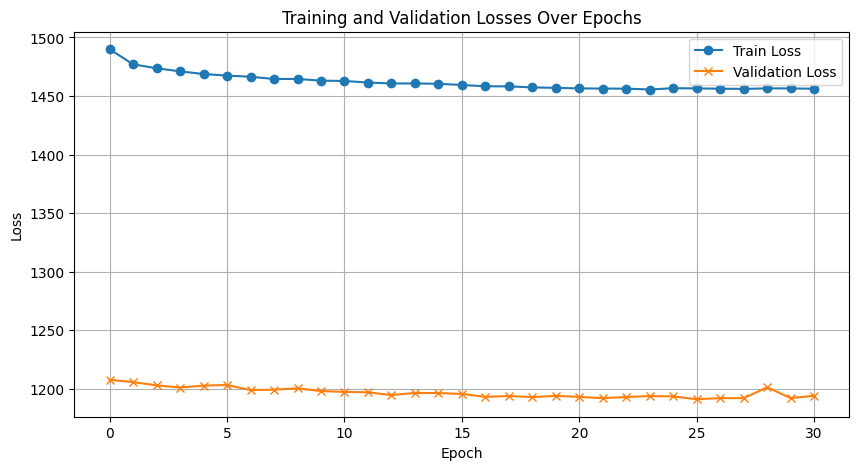

In [103]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_rnn, label="Train Loss", marker="o")
plt.plot(val_losses_rnn, label="Validation Loss", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [105]:
model_rnn.load_state_dict(torch.load("../models/rnn/best_model.pt"))

<All keys matched successfully>

In [106]:
y_true_rnn, y_pred_rnn = evaluate_model(model_rnn, test_loader, device)

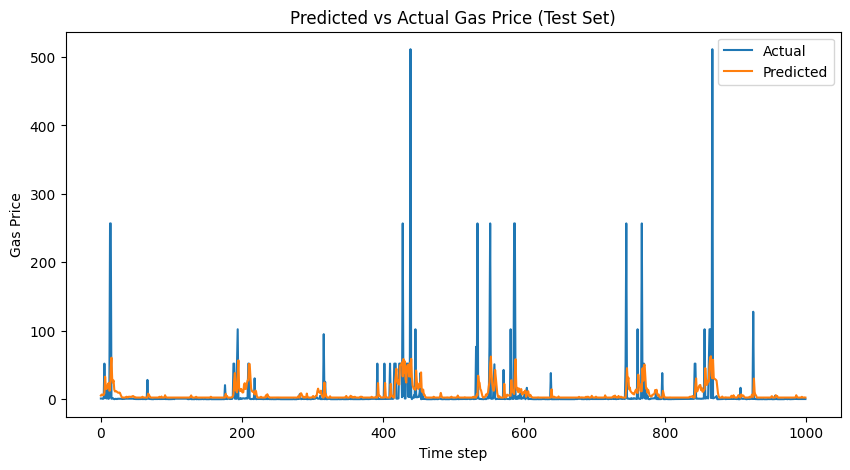

In [ ]:
plot_predictions(y_true_rnn[:1000], y_pred_rnn[:1000], title="Predicted vs Actual Gas Price (Test Set)")

In [109]:
metrics_rnn = calculate_metrics(y_true_rnn, y_pred_rnn)
print(metrics_rnn)

{'MAPE': np.float32(7204.226), 'MAE': np.float32(10.788948)}


## LSTM

In [126]:
hidden_size_lstm = input_size * 4
num_layers_lstm = 2

In [129]:
model_lstm = BasicLSTM(
    input_size,
    hidden_size_lstm,
    num_layers_lstm,
    output_size,
    dropout_rate=0.2,
).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

In [ ]:
train_losses_lstm, val_losses_lstm = train_model(
    model_lstm,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=50,
    patience=5,
    model_path="../models/lstm/best_model.pt",
)

Epoch 1/50: Train Loss = 1455.6922, Val Loss = 1187.0587
  --> Validation loss improved. Model saved to ../models/lstm/best_model.pt
Epoch 2/50: Train Loss = 1434.2793, Val Loss = 1183.7484
  --> Validation loss improved. Model saved to ../models/lstm/best_model.pt
Epoch 3/50: Train Loss = 1431.4486, Val Loss = 1181.5511
  --> Validation loss improved. Model saved to ../models/lstm/best_model.pt
Epoch 4/50: Train Loss = 1429.5841, Val Loss = 1178.8360
  --> Validation loss improved. Model saved to ../models/lstm/best_model.pt
Epoch 5/50: Train Loss = 1427.1911, Val Loss = 1176.1378
  --> Validation loss improved. Model saved to ../models/lstm/best_model.pt
Epoch 6/50: Train Loss = 1425.3710, Val Loss = 1177.3894
  --> No improvement for 1 epoch(s).
Epoch 7/50: Train Loss = 1424.7538, Val Loss = 1178.2111
  --> No improvement for 2 epoch(s).
Epoch 8/50: Train Loss = 1424.5585, Val Loss = 1173.3590
  --> Validation loss improved. Model saved to ../models/lstm/best_model.pt
Epoch 9/50: Tr

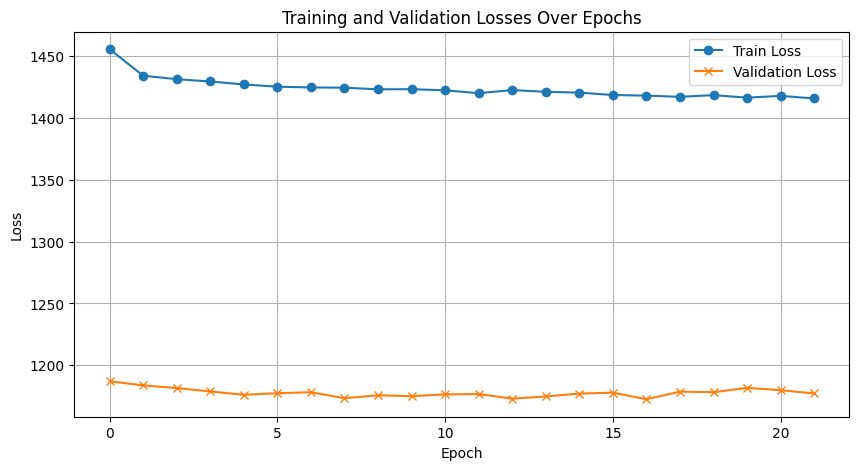

In [132]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_lstm, label="Train Loss", marker="o")
plt.plot(val_losses_lstm, label="Validation Loss", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [133]:
model_lstm.load_state_dict(torch.load("../models/lstm/best_model.pt"))

<All keys matched successfully>

In [134]:
y_true_lstm, y_pred_lstm = evaluate_model(model_lstm, test_loader, device)

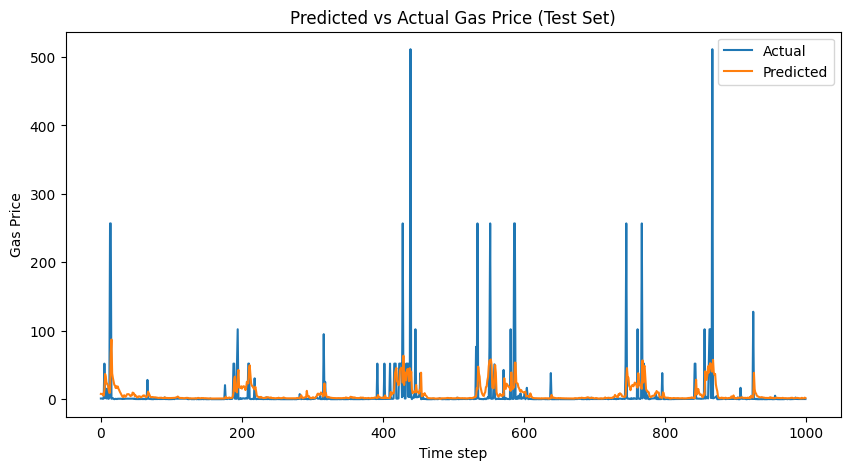

In [135]:
plot_predictions(y_true_lstm[:1000], y_pred_lstm[:1000], title="Predicted vs Actual Gas Price (Test Set)")

In [136]:
metrics_lstm = calculate_metrics(y_true_lstm, y_pred_lstm)
print(metrics_lstm)

{'MAPE': np.float32(7308.682), 'MAE': np.float32(10.698312)}


## Bidirectional LSTM

In [39]:
hidden_size_bi_lstm = input_size * 4
num_layers_bi_lstm = 2

In [40]:
model_bi_lstm = BasicBiLSTM(
    input_size,
    hidden_size_bi_lstm,
    num_layers_bi_lstm,
    output_size,
    dropout_rate=0.2,
).to(device)
optimizer = torch.optim.Adam(model_bi_lstm.parameters(), lr=0.001)

In [41]:
train_losses_bi_lstm, val_losses_bi_lstm = train_model(
    model_bi_lstm,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=50,
    patience=5,
    model_path="../models/bi_lstm/best_model.pt",
)

Epoch 1/50: Train Loss = 1447.6995, Val Loss = 1186.0101
  --> Validation loss improved. Model saved to ../models/bi_lstm/best_model.pt
Epoch 2/50: Train Loss = 1431.6109, Val Loss = 1185.6846
  --> Validation loss improved. Model saved to ../models/bi_lstm/best_model.pt
Epoch 3/50: Train Loss = 1429.4991, Val Loss = 1183.3088
  --> Validation loss improved. Model saved to ../models/bi_lstm/best_model.pt
Epoch 4/50: Train Loss = 1427.1089, Val Loss = 1179.5465
  --> Validation loss improved. Model saved to ../models/bi_lstm/best_model.pt
Epoch 5/50: Train Loss = 1426.0760, Val Loss = 1178.0128
  --> Validation loss improved. Model saved to ../models/bi_lstm/best_model.pt
Epoch 6/50: Train Loss = 1424.2421, Val Loss = 1179.1012
  --> No improvement for 1 epoch(s).
Epoch 7/50: Train Loss = 1424.1726, Val Loss = 1177.4913
  --> Validation loss improved. Model saved to ../models/bi_lstm/best_model.pt
Epoch 8/50: Train Loss = 1423.3318, Val Loss = 1179.4363
  --> No improvement for 1 epoch(

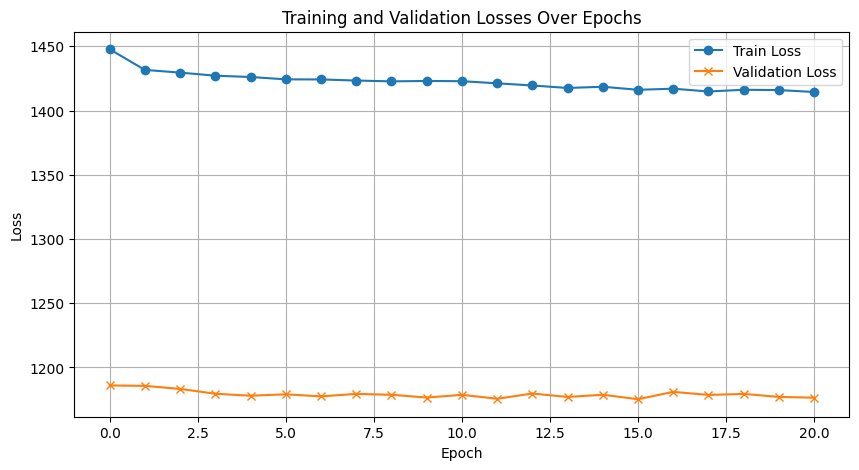

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_bi_lstm, label="Train Loss", marker="o")
plt.plot(val_losses_bi_lstm, label="Validation Loss", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
model_bi_lstm.load_state_dict(torch.load("../models/bi_lstm/best_model.pt"))

<All keys matched successfully>

In [44]:
y_true_bi_lstm, y_pred_bi_lstm = evaluate_model(model_bi_lstm, test_loader, device)

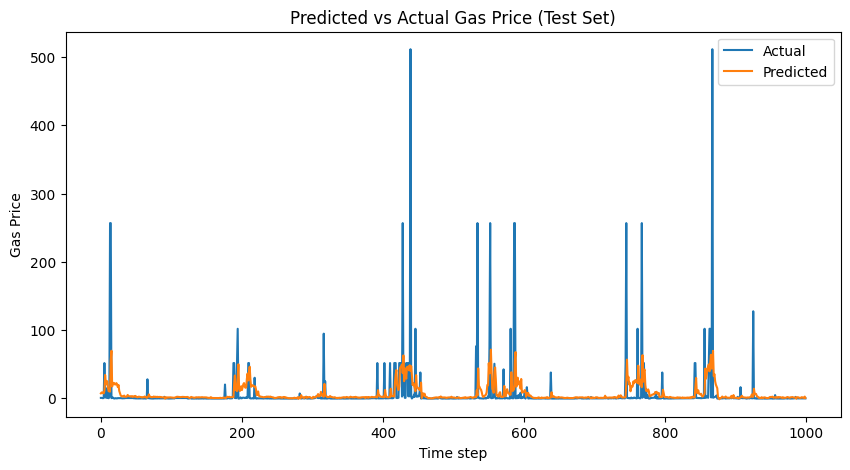

In [45]:
plot_predictions(y_true_bi_lstm[:1000], y_pred_bi_lstm[:1000], title="Predicted vs Actual Gas Price (Test Set)")

In [46]:
metrics_bi_lstm = calculate_metrics(y_true_bi_lstm, y_pred_bi_lstm)
print(metrics_bi_lstm)

{'MAPE': np.float32(6641.287), 'MAE': np.float32(10.238921)}


## CNN LSTM

In [33]:
lstm_cnn_conv_filters = 9
lstm_cnn_kernel_size = 7
lstm_cnn_hidden_size = input_size * 4
lstm_cnn_num_layers = 2

In [34]:
model_cnn_lstm = CNNLSTM(
    input_size,
    lstm_cnn_conv_filters,
    lstm_cnn_kernel_size,
    lstm_cnn_hidden_size,
    lstm_cnn_num_layers,
    output_size,
    dropout_rate=0.2,
    padding=True,
).to(device)
optimizer = torch.optim.Adam(model_cnn_lstm.parameters(), lr=0.001)

In [148]:
train_losses_cnn_lstm, val_losses_cnn_lstm = train_model(
    model_cnn_lstm,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=50,
    patience=5,
    model_path="../models/cnn_lstm/best_model.pt",
)

Epoch 1/50: Train Loss = 1462.3345, Val Loss = 1195.2608
  --> Validation loss improved. Model saved to ../models/bi_lstm/best_model.pt
Epoch 2/50: Train Loss = 1439.6487, Val Loss = 1189.4970
  --> Validation loss improved. Model saved to ../models/bi_lstm/best_model.pt
Epoch 3/50: Train Loss = 1432.6851, Val Loss = 1188.8166
  --> Validation loss improved. Model saved to ../models/bi_lstm/best_model.pt
Epoch 4/50: Train Loss = 1427.2634, Val Loss = 1183.6311
  --> Validation loss improved. Model saved to ../models/bi_lstm/best_model.pt
Epoch 5/50: Train Loss = 1426.4486, Val Loss = 1185.5276
  --> No improvement for 1 epoch(s).
Epoch 6/50: Train Loss = 1422.5430, Val Loss = 1187.7056
  --> No improvement for 2 epoch(s).
Epoch 7/50: Train Loss = 1420.4424, Val Loss = 1185.9571
  --> No improvement for 3 epoch(s).
Epoch 8/50: Train Loss = 1420.0776, Val Loss = 1186.9478
  --> No improvement for 4 epoch(s).
Epoch 9/50: Train Loss = 1415.6882, Val Loss = 1190.5130
  --> No improvement fo

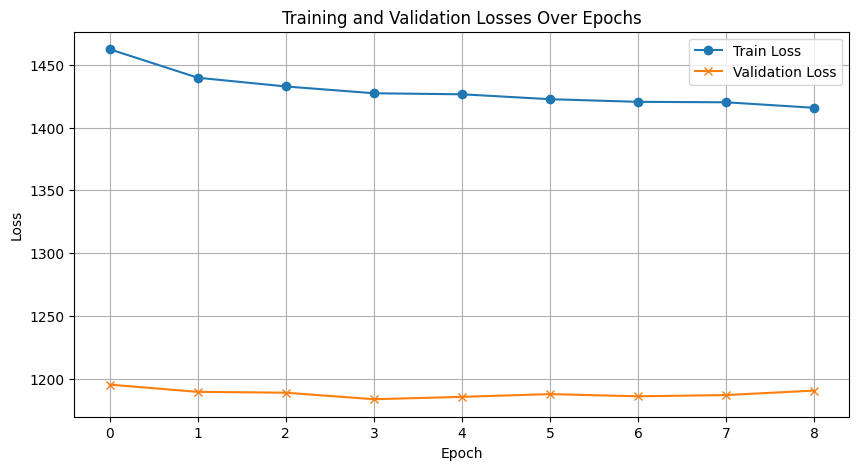

In [149]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_cnn_lstm, label="Train Loss", marker="o")
plt.plot(val_losses_cnn_lstm, label="Validation Loss", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
model_cnn_lstm.load_state_dict(torch.load("../models/cnn_lstm/best_model.pt"))

<All keys matched successfully>

In [36]:
y_true_cnn_lstm, y_pred_cnn_lstm = evaluate_model(model_cnn_lstm, test_loader, device)

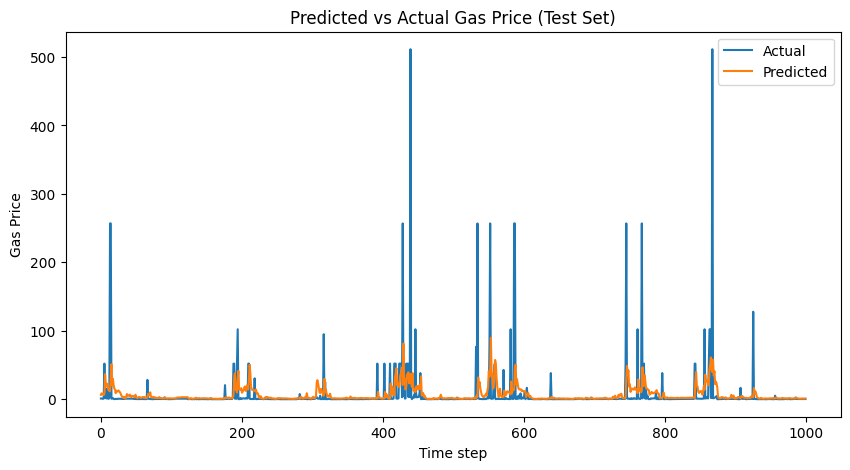

In [37]:
plot_predictions(y_true_cnn_lstm[:1000], y_pred_cnn_lstm[:1000], title="Predicted vs Actual Gas Price (Test Set)")

In [38]:
metrics_cnn_lstm = calculate_metrics(y_true_cnn_lstm, y_pred_cnn_lstm)
print(metrics_cnn_lstm)

{'MAPE': np.float32(6197.7974), 'MAE': np.float32(10.336448)}


## Attention LSTM

In [20]:
hidden_size_attention_lstm = input_size * 4
num_layers_attention_lstm = 2

In [23]:
model_attention_lstm = AttentionLSTM(
    input_size,
    hidden_size_attention_lstm,
    num_layers_attention_lstm,
    output_size,
    dropout_rate=0.2,
).to(device)
optimizer = torch.optim.Adam(model_attention_lstm.parameters(), lr=0.001)

In [24]:
train_losses_attention_lstm, val_losses_attention_lstm = train_model(
    model_attention_lstm,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=50,
    patience=5,
    model_path="../models/attention_lstm/best_model.pt",
)

Epoch 1/50: Train Loss = 1508.3919, Val Loss = 1200.9000
  --> Validation loss improved. Model saved to ../models/attention_lstm/best_model.pt
Epoch 2/50: Train Loss = 1447.0460, Val Loss = 1191.1298
  --> Validation loss improved. Model saved to ../models/attention_lstm/best_model.pt
Epoch 3/50: Train Loss = 1440.9145, Val Loss = 1190.2445
  --> Validation loss improved. Model saved to ../models/attention_lstm/best_model.pt
Epoch 4/50: Train Loss = 1437.4464, Val Loss = 1186.0245
  --> Validation loss improved. Model saved to ../models/attention_lstm/best_model.pt
Epoch 5/50: Train Loss = 1437.6909, Val Loss = 1184.9305
  --> Validation loss improved. Model saved to ../models/attention_lstm/best_model.pt
Epoch 6/50: Train Loss = 1436.3530, Val Loss = 1184.0189
  --> Validation loss improved. Model saved to ../models/attention_lstm/best_model.pt
Epoch 7/50: Train Loss = 1433.5268, Val Loss = 1182.4226
  --> Validation loss improved. Model saved to ../models/attention_lstm/best_model.pt

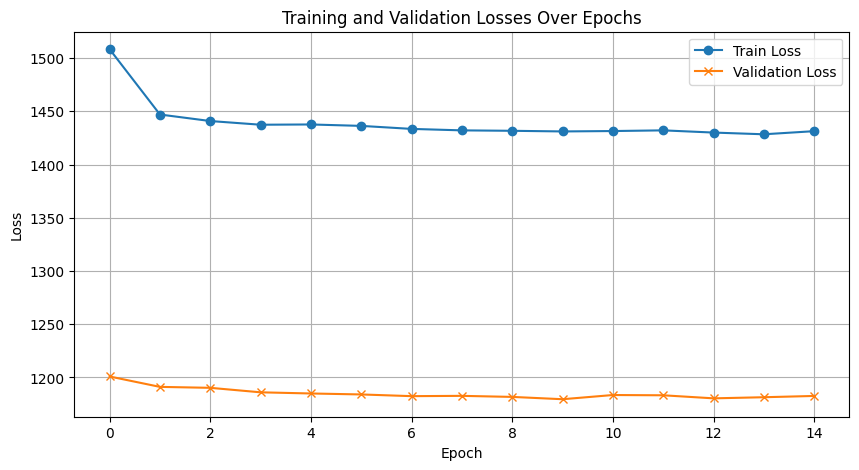

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_attention_lstm, label="Train Loss", marker="o")
plt.plot(val_losses_attention_lstm, label="Validation Loss", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
model_attention_lstm.load_state_dict(torch.load("../models/attention_lstm/best_model.pt"))

<All keys matched successfully>

In [27]:
y_true_attention_lstm, y_pred_attention_lstm = evaluate_model(model_attention_lstm, test_loader, device)

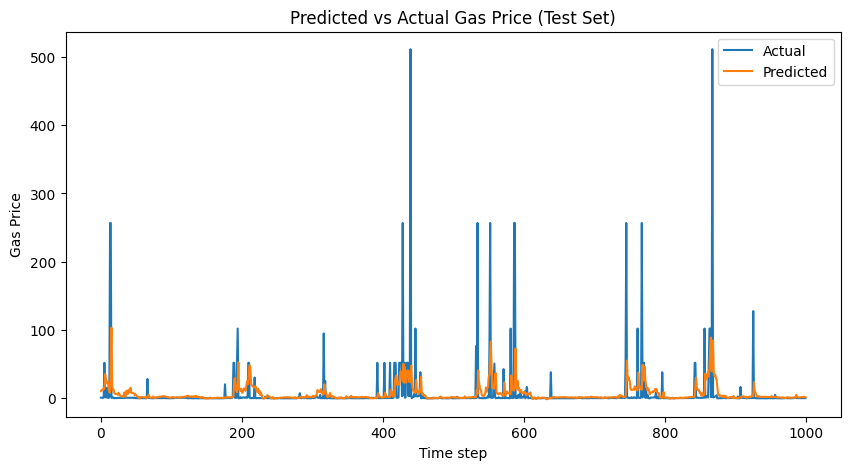

In [28]:
plot_predictions(
    y_true_attention_lstm[:1000], y_pred_attention_lstm[:1000], title="Predicted vs Actual Gas Price (Test Set)"
)

In [30]:
metrics_attention_lstm = calculate_metrics(y_true_attention_lstm, y_pred_attention_lstm)
print(metrics_attention_lstm)

{'MAPE': np.float32(6409.6), 'MAE': np.float32(10.280424)}


## Conclusion

- We've chosen common regression metrics for evaluation: MAPE and MAE. First is more representative since the target was scaled with RobustScaler()
- We have abandoned the idea of validating at checkpoints like 5m, 10m, etc. as it would be unfair - cherry picking.🍒 
- Best we could reach was MAPE ~= 6200%, so our prediction error is 62 times the correct value 😭
- Judging by plots, we're doing solid job in predicting common gas price and small "waves", but on giant outliers we do perform bad
- Best model we created was a CNN LSTM, which was suggested by the article 🤝

In [48]:
results = {
    "rnn": {"MAPE": np.float32(7204.226), "MAE": np.float32(10.788948)},
    "lstm": {"MAPE": np.float32(7308.682), "MAE": np.float32(10.698312)},
    "bi-lstm": {"MAPE": np.float32(6641.287), "MAE": np.float32(10.238921)},
    "cnn-lstm": {"MAPE": np.float32(6197.7974), "MAE": np.float32(10.336448)},
    "attention-lstm": {"MAPE": np.float32(6409.6), "MAE": np.float32(10.280424)},
}

In [49]:
df_quality = pd.DataFrame(results).T
df_quality.index.name = "Model"

In [50]:
styled_df = df_quality.style.highlight_min(color="lightgreen", axis=0)
styled_df

,MAPE,MAE
Model,,
rnn,7204.226074,10.788948
lstm,7308.682129,10.698312
bi-lstm,6641.287109,10.238921
cnn-lstm,6197.797363,10.336448
attention-lstm,6409.600098,10.280424


### Possible improvements

1. Reformulate the problem into a simplified one
2. Collect more data on transactions, pay attention to outliers
3. Try to predict not price, but price change (difference between neighboring prices) to smooth the target
4. Train a model to predict outliers, consider its prediction in ensemble with the baseline